# PEC 3 DISEÑO E IMPLEMENTACIÓN DEL TRABAJO

## TFM GESTIÓN AVANZADA DE INVENTARIO. Machine Learning aplicado a la predicción de la demanda.

### 1.- PREPARACIÓN DEL FICHERO.   

###     1.1.-      Lectura ficheros de datos
Se llama a Pandas para lectura de ficheros Excel

Importar las librerías y funciones necesarias para esta primera fase.

In [1]:
import pandas as pd
import datetime
from datetime import datetime, timedelta
from pandas import DataFrame, Timestamp
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

##### 1.1.1- Fichero ventas
Se comienza con la lectura del fichero de unidades vendidas por cada sku, a una fecha determinada. Recordar que la variable sku es una referencia única para la combinación producto - tienda. Se desconoce la ubicación física de cada tienda.

In [2]:
ventas = pd.read_excel('data/Datos7.xls', sheet_name='Venta')
ventas.head()

,sku,fecha,udsVenta
0,1,20200519,35
1,1,20200520,28
2,1,20200521,63
3,1,20200522,42
4,1,20200523,28


In [3]:
# Fechas máximo y mínimo
print('Fecha inicio de observaciones {}.' .format(ventas['fecha'].min()))
print('Fecha final de observaciones {}.' .format(ventas['fecha'].max()))
print('Dimensión del fichero {}.' .format(ventas.shape))

Fecha inicio de observaciones 20200314.
Fecha final de observaciones 20220314.
Dimensión del fichero (34151, 3).


##### 1.1.2.- Fichero calendario.  
El fichero calendarios recoge si a una fecha determinada y para cada sku, la tienda está abierta y se trata de un día festivo.

In [4]:
# lectura de la hoja calendarios
calendario = pd.read_excel('data/Datos7.xls', sheet_name='Calendarios')
calendario.head()

,sku,fecha,bolOpen,bolHoliday
0,21,20211103,1,0
1,21,20211027,1,0
2,21,20211028,1,0
3,21,20211030,1,0
4,21,20211029,1,0


El fichero calendario recoge dos variables booleanas (bolOpen y bolHoliday) que indica si el establecimiento está abierto y si es fecha de vacaciones. No son valores disjuntos de modo que una fecha que indica vacaciones, la tienda puede estar abierta (1.113 casos). También existen fechas en las que sin ser vacaciones,  la tienda está cerrada (604 casos).  
Se puede comprobar en la siguiente tabla cruzada

In [5]:
# Comprobación tabla cruzada según valores de las variables bolOpen y bolHoliday.
pd.crosstab(
    calendario.bolOpen, 
    calendario.bolHoliday,  
    rownames = ['Abierto'],
    colnames = ['Festivo'],
    margins = True, 
    margins_name = 'subtotal')

Festivo,0,1,subtotal
Abierto,,,
0,604,4753,5357
1,51780,1113,52893
subtotal,52384,5866,58250


In [6]:
# Número de fechas por cada sku
calendario.groupby('sku').count()

,fecha,bolOpen,bolHoliday
sku,,,
1,1165,1165,1165
2,1165,1165,1165
3,1165,1165,1165
4,1165,1165,1165
5,1165,1165,1165
6,1165,1165,1165
7,1165,1165,1165
8,1165,1165,1165
9,1165,1165,1165


In [7]:
# Fechas máximo y mínimo
print('Fecha inicio de observaciones {}.' .format(calendario['fecha'].min()))
print('Fecha final de observaciones {}.' .format(calendario['fecha'].max()))
print('Dimensión del fichero {}.' .format(calendario.shape))

Fecha inicio de observaciones 20200315.
Fecha final de observaciones 20230523.
Dimensión del fichero (58250, 4).


El fichero calendario consta de 1.165 observaciones por cada sku (58.250 observaciones en total), y abarca desde el 15/03/2020 al 23/05/2023. Existen más fechas que en el fichero ventas.  

##### 1.1.3 Fichero promos.  
El fichero promos identifica los periodos (fecha inicio y fecha fin) en los que un sku (product/tienda) se ha incluido en una promoción determinada. 

In [8]:
# lectura de la hoja promos
promos = pd.read_excel('data/Datos7.xls', sheet_name='Promos')
promos.head()

,sku,fecha ini,fecha fin
0,35,20220113,20220223
1,32,20200626,20200723
2,16,20120314,20120409
3,29,20130920,20131121
4,29,20210311,20210407


In [9]:
# Fechas máximo y mínimo
print('Fecha inicio de observaciones {}.' .format(promos['fecha ini'].min()))
print('Fecha final de observaciones {}.' .format(promos['fecha fin'].max()))
print('Dimensión del fichero {}.' .format(promos.shape))

Fecha inicio de observaciones 20110104.
Fecha final de observaciones 20220420.
Dimensión del fichero (2128, 3).


Interesa de este fichero, las observaciones de sku que se encuentran en promoción, durante el periodo de estudio comprendido entre el 14/03/2020 y el 14/03/2022.  
Número de promociones por cada sku y duración de cada una de las promociones. 

In [10]:
# Número de promociones por cada sku
num_promos = promos.groupby('sku', as_index=False).agg('count')

Interesa conocer también, la duración de la promoción, en días. Para ello, y antes de la unión de los ficheros, se crea en el fichero promos, una nueva columna con el valor de duración de la promoción, en días.

In [11]:
# Cambio formato en la columna fecha
promos['date_ini'] = pd.to_datetime(promos['fecha ini'].astype(str), format='%Y%m%d')
promos['date_fin'] = pd.to_datetime(promos['fecha fin'].astype(str), format='%Y%m%d')

# Creación de la variable duración de la promoción (en dias)
promos['duracion'] = (promos['date_fin'] - promos['date_ini']).dt.days

In [12]:
duracion_promos = promos.groupby('sku', as_index=False).sum()

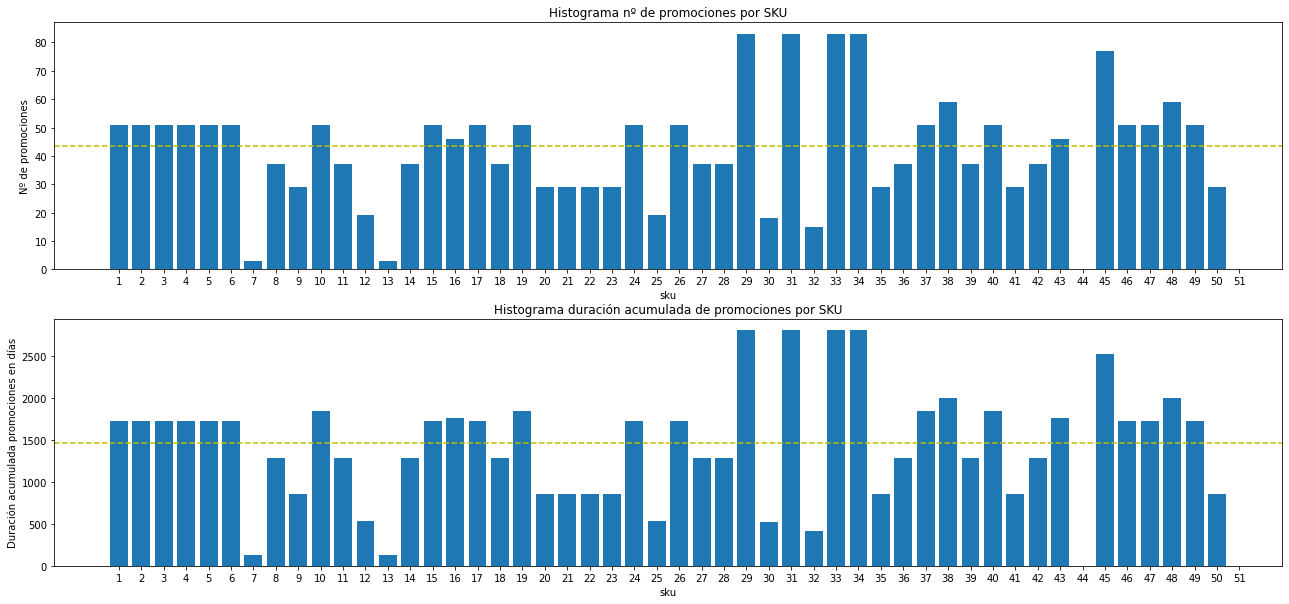

In [16]:
# Representación histograma número de promociones por sku.
intervalo = range(min(promos["sku"]), max(promos["sku"])+2)
plt.figure(figsize = (22,10))

plt.subplot (2,1,1)
plt.bar(num_promos["sku"],num_promos['fecha ini'])
plt.xlabel('sku')
plt.ylabel('Nº de promociones')
plt.axhline(num_promos['fecha ini'].mean(), color='y', linestyle='dashed')
plt.xticks(intervalo)
plt.title ('Histograma nº de promociones por SKU')

plt.subplot (2,1,2)
plt.bar(duracion_promos['sku'], duracion_promos['duracion'])
plt.xlabel('sku')
plt.ylabel('Duración acumulada promociones en días')
plt.axhline(duracion_promos['duracion'].mean(), color='y', linestyle='dashed')
plt.xticks(intervalo)
plt.title ('Histograma duración acumulada de promociones por SKU')
plt.show()

Se observa que la variable sku = 44 no tiene ninguna promoción asignada. 
Existe una relación directa entre el número de promociones y la duración total de las mismas. Puede afirmarse que las promociones son de una duración similar.
Existen 6 valores de sku (7, 12, 13, 25, 30 y 32) con número de promociones muy inferior al resto. Así mismo, los valores de sku (29, 31, 33, 34 y 45) cuenta con número de promociones ampliamente superior al resto.  

##### 1.1.4.- Fichero stock

In [17]:
# Lectura del fichero stock

stock = pd.read_excel('data/Datos7.xls', sheet_name='Stock')
stock.head()

,sku,fecha,udsStock
0,1,20200315,441
1,1,20200316,441
2,1,20200317,441
3,1,20200318,441
4,1,20200319,441


In [18]:
print('Dimensión del fichero {}.' .format(stock.shape))

Dimensión del fichero (36550, 3).


##### 1.1.5.- Fichero ciclo

In [19]:
# Lectura fichero ciclo.

ciclo = pd.read_excel('data/DatosCicloAprovisionamiento.xls')
ciclo.head()

,sku,diasEntrePedidos,diasLeadtime
0,17,28,4
1,19,7,2
2,26,15,4
3,28,14,4
4,14,15,2


In [20]:
ciclo.info()
print('Dimensión del fichero {}.' .format(ciclo.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
sku                 50 non-null int64
diasEntrePedidos    50 non-null int64
diasLeadtime        50 non-null int64
dtypes: int64(3)
memory usage: 1.3 KB
Dimensión del fichero (50, 3).


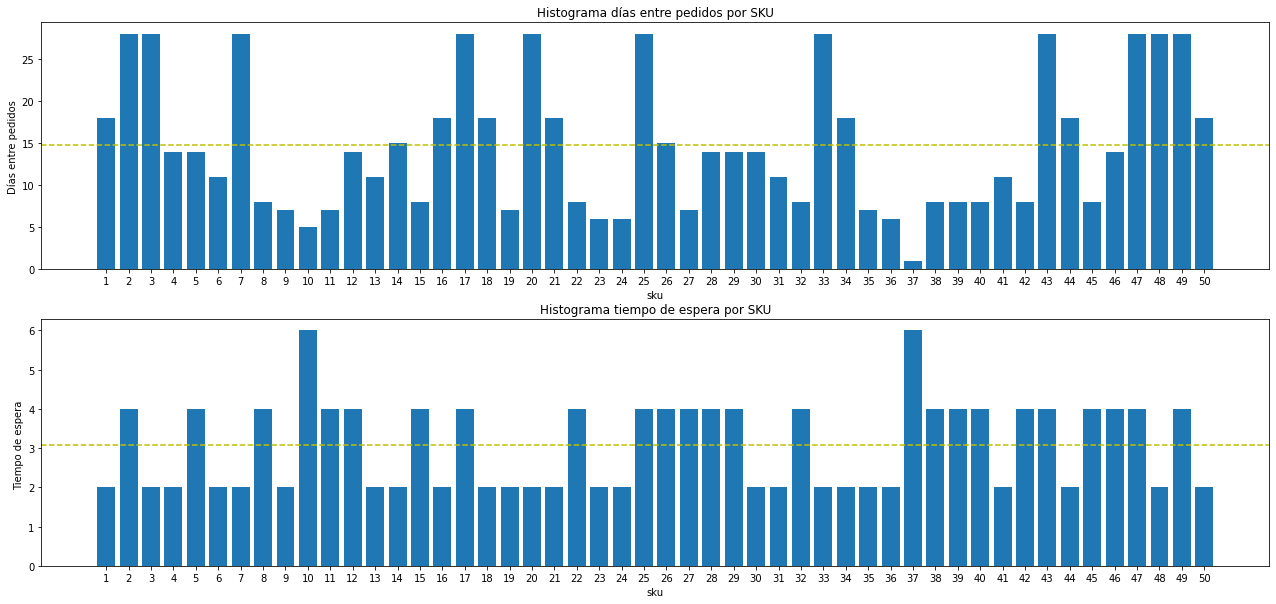

In [21]:
# Representación histograma número de promociones por sku.
intervalo = range(min(ciclo["sku"]), max(ciclo["sku"])+1)
plt.figure(figsize = (22,10))

plt.subplot (2,1,1)
plt.bar(ciclo["sku"], ciclo['diasEntrePedidos'])
plt.xlabel('sku')
plt.ylabel('Días entre pedidos')
plt.axhline(ciclo['diasEntrePedidos'].mean(), color='y', linestyle='dashed')
plt.xticks(intervalo)
plt.title ('Histograma días entre pedidos por SKU')

plt.subplot (2,1,2)
plt.bar(ciclo['sku'], ciclo['diasLeadtime'])
plt.xlabel('sku')
plt.ylabel('Tiempo de espera ')
plt.axhline(ciclo['diasLeadtime'].mean(), color='y', linestyle='dashed')
plt.xticks(intervalo)
plt.title ('Histograma tiempo de espera por SKU')
plt.show()

##### 1.1.6 Fichero precio medio

In [22]:
# Lectura ficheor precio medio

precio = pd.read_excel('data/DatosPrecioMedio.xls')
precio.head()

,idSkuIta,eurPrecioMedio
0,1,1.370002
1,2,1.370002
2,3,1.370002
3,4,1.370002
4,5,1.370002


In [23]:
precio.info()
print('Dimensión del fichero {}.' .format(precio.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
idSkuIta          50 non-null int64
eurPrecioMedio    50 non-null float64
dtypes: float64(1), int64(1)
memory usage: 928.0 bytes
Dimensión del fichero (50, 2).


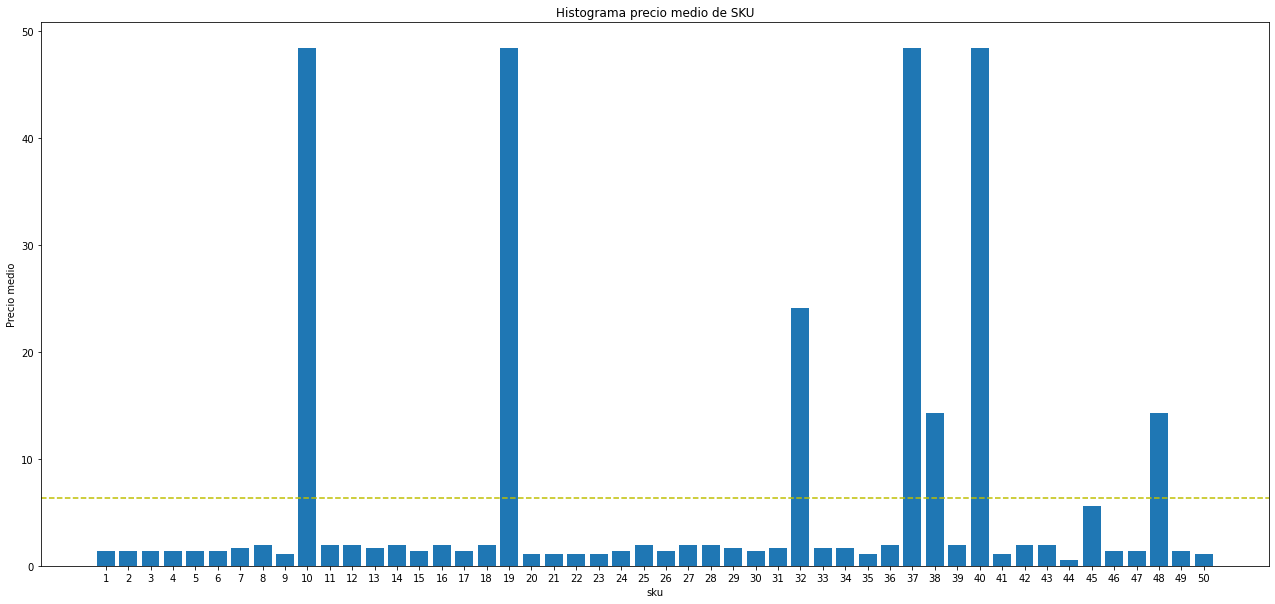

In [24]:
# Representación histograma número de promociones por sku.
intervalo = range(min(precio["idSkuIta"]), max(precio["idSkuIta"])+1)
plt.figure(figsize = (22,10))

plt.bar(precio["idSkuIta"], precio['eurPrecioMedio'])
plt.xlabel('sku')
plt.ylabel('Precio medio')
plt.axhline(precio['eurPrecioMedio'].mean(), color='y', linestyle='dashed')
plt.xticks(intervalo)
plt.title ('Histograma precio medio de SKU')
plt.show()

### 1.2.- Unión de ficheros.   
Interesa unir la información de los diferentes ficheros en un único fichero, que será la fuente para diseñar el modelo de predicción/clasificación. Se toma como fichero principal el de *ventas* al que añadiremos las siguientes columnas, utilizando como referencia el valor de la variable sku.  

##### 1.2.1 variables bolOpen y bolHoliday del fichero *calendario*.  

In [25]:
# Tamaño de los ficheros a concatenar.
ventas.info()
calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34151 entries, 0 to 34150
Data columns (total 3 columns):
sku         34151 non-null int64
fecha       34151 non-null int64
udsVenta    34151 non-null int64
dtypes: int64(3)
memory usage: 800.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58250 entries, 0 to 58249
Data columns (total 4 columns):
sku           58250 non-null int64
fecha         58250 non-null int64
bolOpen       58250 non-null int64
bolHoliday    58250 non-null int64
dtypes: int64(4)
memory usage: 1.8 MB


In [26]:
# Concatenar los ficheros ventas + calendario, que se llamará venta.
# Utilizar condición de unión, siempre que coincidan los valores de las variables sku y fecha.
# Se une con la condición inner, dado que las fechas de inicio y fin de observaciones en 
# los ficheros ventas y calendario difieren.

venta = ventas.merge(calendario, on=('sku', 'fecha'), how='inner')
venta.head(10)

,sku,fecha,udsVenta,bolOpen,bolHoliday
0,1,20200519,35,1,0
1,1,20200520,28,1,0
2,1,20200521,63,1,0
3,1,20200522,42,1,0
4,1,20200523,28,1,0
5,1,20200524,0,0,1
6,1,20200525,42,1,0
7,1,20200526,56,1,0
8,1,20200527,35,1,0
9,1,20200528,28,1,0


In [27]:
venta.describe()

,sku,fecha,udsVenta,bolOpen,bolHoliday
count,34138.000000,3.413800e+04,34138.000000,34138.000000,34138.000000
mean,25.547689,2.020817e+07,13.635421,0.860361,0.165886
std,14.480658,6.166929e+03,16.451301,0.346617,0.371983
min,1.000000,2.020032e+07,-91.000000,0.000000,0.000000
25%,13.000000,2.020102e+07,0.000000,1.000000,0.000000
50%,26.000000,2.021041e+07,7.000000,1.000000,0.000000
75%,38.000000,2.021092e+07,21.000000,1.000000,0.000000
max,50.000000,2.022031e+07,273.000000,1.000000,1.000000


In [28]:
# Fechas máximo y mínimo
print('Fecha inicio de observaciones {}.' .format(venta['fecha'].min()))
print('Fecha final de observaciones {}.' .format(venta['fecha'].max()))
print('Dimensión del fichero {}.' .format(venta.shape))

Fecha inicio de observaciones 20200315.
Fecha final de observaciones 20220314.
Dimensión del fichero (34138, 5).


##### 1.2.2 variables bolPromo y durac_promo.   
Se une ahora al fichero venta, la información contenida en el fichero promos. Se añade al fichero venta una nueva variable boolena, llamada bolPromo con valor 1 si el sku tiene alguna campaña promocional en la fecha de observación, o 0 en caso contrario.  

In [29]:
promos.head()

,sku,fecha ini,fecha fin,date_ini,date_fin,duracion
0,35,20220113,20220223,2022-01-13,2022-02-23,41
1,32,20200626,20200723,2020-06-26,2020-07-23,27
2,16,20120314,20120409,2012-03-14,2012-04-09,26
3,29,20130920,20131121,2013-09-20,2013-11-21,62
4,29,20210311,20210407,2021-03-11,2021-04-07,27


Cambiar el formato de la columna fecha en el fichero venta.

In [30]:
# Cambio formato en la columna fecha
venta['date'] = pd.to_datetime(venta['fecha'].astype(str), format='%Y%m%d')

In [31]:
venta.head()

,sku,fecha,udsVenta,bolOpen,bolHoliday,date
0,1,20200519,35,1,0,2020-05-19
1,1,20200520,28,1,0,2020-05-20
2,1,20200521,63,1,0,2020-05-21
3,1,20200522,42,1,0,2020-05-22
4,1,20200523,28,1,0,2020-05-23


In [32]:
# Unión de los ficheros venta y promos.
# Creación de variable booleana bolPromo que indica si un sku está promocionado
# en una fecha determinada
# Incorporación de la variable durac_promo que indica la duración en día de
# la promoción.

venta['bolPromo'] = 0
venta['durac_promo'] = 0
for i in range(0, len(venta)-1):
    aa = venta.iloc[i,0]
    ab = venta.iloc[i,5]
    for j in range (0, len(promos)-1):
        ba = promos.iloc[j,0]
        bb = promos.iloc[j,3]
        bc = promos.iloc[j,4]
        if aa == ba and ab >= bb and ab <= bc:
            venta.iloc[i,6] = 1
            venta.iloc[i,7] = promos.iloc[j,5]    


In [33]:
# Indexar el fichero a partir de la variable date.

venta_index = venta.set_index('date')

In [34]:
venta_index.head()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo
date,,,,,,,
2020-05-19,1,20200519,35,1,0,0,0
2020-05-20,1,20200520,28,1,0,0,0
2020-05-21,1,20200521,63,1,0,0,0
2020-05-22,1,20200522,42,1,0,0,0
2020-05-23,1,20200523,28,1,0,0,0


In [35]:
# Observaciones que cuentas con una promoción, o no.
# Total de observaciones 34.138.

venta.groupby('bolPromo').count()

,sku,fecha,udsVenta,bolOpen,bolHoliday,date,durac_promo
bolPromo,,,,,,,
0,17965,17965,17965,17965,17965,17965,17965
1,16173,16173,16173,16173,16173,16173,16173


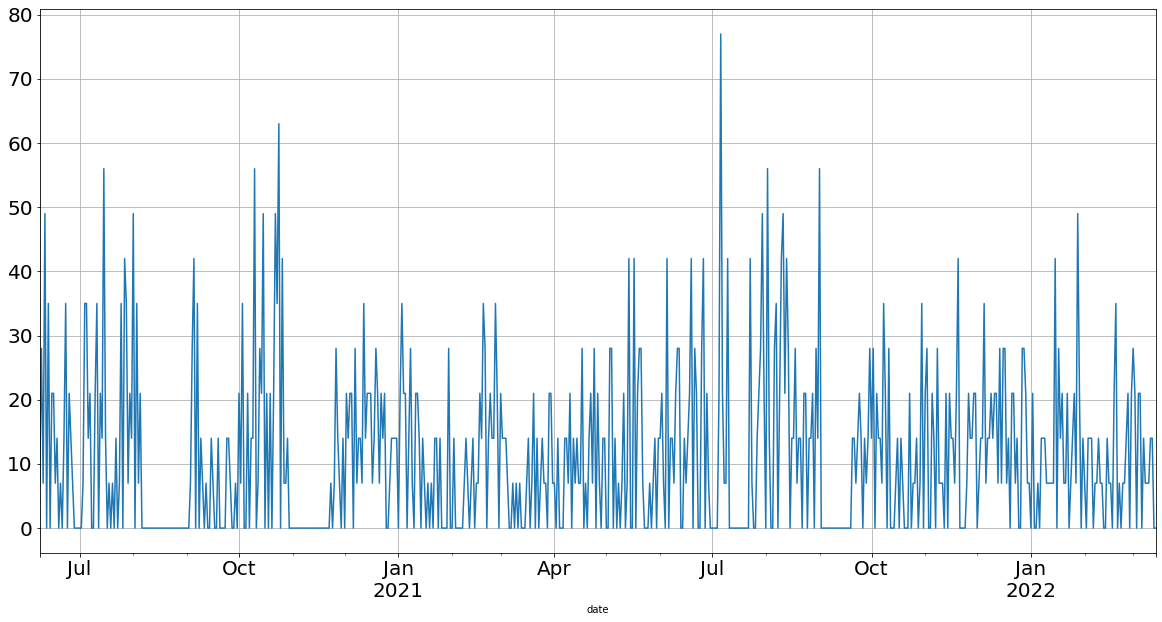

In [36]:
# Gráfico estacionalidad para sku=30

venta_sku30 = venta_index[venta_index['sku'] == 30]
plt.figure(figsize=(20,10))
venta_sku30['udsVenta'].plot()
plt.tick_params(labelsize=20)
plt.grid()

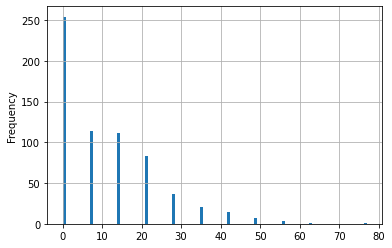

In [37]:
# Histograma

venta_sku30['udsVenta'].plot(kind='hist',bins=100)
plt.grid()

##### 1.2.3.- Unión del fichero stock.

In [39]:
# Dimensión del fichero stock

stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36550 entries, 0 to 36549
Data columns (total 3 columns):
sku         36550 non-null int64
fecha       36550 non-null int64
udsStock    36550 non-null int64
dtypes: int64(3)
memory usage: 856.8 KB


In [40]:
# Fechas máximo y mínimo del fichero stock
print('Fecha inicio de observaciones {}.' .format(stock['fecha'].min()))
print('Fecha final de observaciones {}.' .format(stock['fecha'].max()))

Fecha inicio de observaciones 20200315.
Fecha final de observaciones 20220315.


In [41]:
# La unión de los ficheros es por coincidencia con la izquierda.

venta = venta.merge(stock, on=('sku', 'fecha'), how='left')
venta.head(10)

,sku,fecha,udsVenta,bolOpen,bolHoliday,date,bolPromo,durac_promo,udsStock
0,1,20200519,35,1,0,2020-05-19,0,0,441
1,1,20200520,28,1,0,2020-05-20,0,0,406
2,1,20200521,63,1,0,2020-05-21,0,0,378
3,1,20200522,42,1,0,2020-05-22,0,0,315
4,1,20200523,28,1,0,2020-05-23,0,0,273
5,1,20200524,0,0,1,2020-05-24,0,0,245
6,1,20200525,42,1,0,2020-05-25,0,0,245
7,1,20200526,56,1,0,2020-05-26,0,0,203
8,1,20200527,35,1,0,2020-05-27,0,0,756
9,1,20200528,28,1,0,2020-05-28,0,0,728


In [42]:
# Fechas máximo y mínimo del nuevo fichero venta_2
print('Fecha inicio de observaciones {}.' .format(venta['fecha'].min()))
print('Fecha final de observaciones {}.' .format(venta['fecha'].max()))

Fecha inicio de observaciones 20200315.
Fecha final de observaciones 20220314.


In [43]:
# Indexar el fichero a partir de la variable date.

venta_index = venta.set_index('date')

In [45]:
venta_index.head(10)

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock
date,,,,,,,,
2020-05-19,1,20200519,35,1,0,0,0,441
2020-05-20,1,20200520,28,1,0,0,0,406
2020-05-21,1,20200521,63,1,0,0,0,378
2020-05-22,1,20200522,42,1,0,0,0,315
2020-05-23,1,20200523,28,1,0,0,0,273
2020-05-24,1,20200524,0,0,1,0,0,245
2020-05-25,1,20200525,42,1,0,0,0,245
2020-05-26,1,20200526,56,1,0,0,0,203
2020-05-27,1,20200527,35,1,0,0,0,756


Se salvan los ficheros procesados hasta este punto, bajo el nombre venta.xls.  

- Contiene la unión de los ficheros ventas + calendario + promoción + stock.  
- La unión de los ficheros ventas y calendario en modalidad _inner_.  
- Periodo de observaciones, del 15/03/2020 al 14/03/2022.  
- La unión al fichero promoción se realiza por búsqueda registro a registro.   
    - Se crea variable booleana bolpromo que toma valor 1 si en la fecha de observación, el sku estaba promocionado.  
    - Se crea variable durac_promo con la duración en días de la promoción realizada por el sku.  
- La unión con el fichero stock en modalidad _left_.   

Se salva una segunda versión del fichero en el que se utiliza la variable _date_ como variable de indexación. Nombre del fichero venta_index.xls

In [46]:
# Grabación del fichero venta_2

venta.to_excel('data/venta.xls', index=False)
venta_index.to_excel('data/venta_index.xls', index=False)

##### 1.2.4.- Unión de los ficheros ciclo y precio medio.    

Ambos ficheros constan de 50 registros, uno por cada sku.

In [47]:
# Renombrar la columna idSkuIta del fihero precio, a sku.
precio.rename(columns={'idSkuIta': 'sku'}, inplace=True)

# Unión de los ficheros ciclo y precio según el valor de sku.
basic = ciclo.merge(precio, on=('sku'), how='inner')
basic.head()

,sku,diasEntrePedidos,diasLeadtime,eurPrecioMedio
0,17,28,4,1.370002
1,19,7,2,48.429457
2,26,15,4,1.370002
3,28,14,4,1.920083
4,14,15,2,1.920083


Se salva el fichero generado por unión de los ficheros cilo y precio medio, bajo el nombre basic.xls.  

In [48]:
# Grabación del fichero basic

basic.to_excel('data/basic.xls', index=False)

### 1.3.- Limpieza de datos.   
Depuración de los ficheros para detección de valores nulos, anómalos y outliers.   

In [3]:
# Principales variables estadísticas descriptivas.  

venta = pd.read_excel('data/venta.xls')
venta.describe()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock
count,34138.000000,3.413800e+04,34138.000000,34138.000000,34138.000000,34138.000000,34138.000000,34138.000000
mean,25.547689,2.020817e+07,13.635421,0.860361,0.165886,0.473754,14.034683,311.596989
std,14.480658,6.166929e+03,16.451301,0.346617,0.371983,0.499318,15.685832,269.632981
min,1.000000,2.020032e+07,-91.000000,0.000000,0.000000,0.000000,0.000000,-147.000000
25%,13.000000,2.020102e+07,0.000000,1.000000,0.000000,0.000000,0.000000,168.000000
50%,26.000000,2.021041e+07,7.000000,1.000000,0.000000,0.000000,0.000000,238.000000
75%,38.000000,2.021092e+07,21.000000,1.000000,0.000000,1.000000,27.000000,350.000000
max,50.000000,2.022031e+07,273.000000,1.000000,1.000000,1.000000,52.000000,2310.000000


##### 1.3.1.- Valores negativos.   
Existen valores en UdsVenta y udsStock, con signo negativo. Identificar estos valores y tomar decisiones.

In [4]:
# Identificar observaciones udsVenta con valor negativo en udsVenta.

uds_venta_negativ = venta.loc[venta["udsVenta"]<0]
uds_venta_negativ

,sku,fecha,udsVenta,bolOpen,bolHoliday,date,bolPromo,durac_promo,udsStock
7321,11,20211002,-7,1,0,2021-10-02,0,0,-7
14326,21,20220114,-91,1,0,2022-01-14,1,41,336
15582,23,20211103,-7,1,0,2021-11-03,0,0,161
18135,27,20210723,-7,1,0,2021-07-23,0,0,154
18227,27,20211023,-35,1,0,2021-10-23,1,27,-35
23699,35,20210921,-70,1,0,2021-09-21,0,0,140
25957,39,20200724,-7,1,0,2020-07-24,0,0,231
26366,39,20210906,-7,1,0,2021-09-06,1,21,21


Todos los sku con valor negativo en udsVenta, corresponde con la fecha de apertura del centro correspondiente a dicho sku. Se considera que ha existido rotura de stock, y deben considerarse valor nulo en udsVenta. Por tanto, reemplazar el valor negativo por el valor 0. 

In [5]:
# Reemplazar valor negativo en la variable udsVenta por valor 0.

venta.loc[venta['udsVenta']<0, 'udsVenta'] = 0

In [6]:
venta.describe()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock
count,34138.000000,3.413800e+04,34138.000000,34138.000000,34138.000000,34138.000000,34138.000000,34138.000000
mean,25.547689,2.020817e+07,13.642188,0.860361,0.165886,0.473754,14.034683,311.596989
std,14.480658,6.166929e+03,16.432636,0.346617,0.371983,0.499318,15.685832,269.632981
min,1.000000,2.020032e+07,0.000000,0.000000,0.000000,0.000000,0.000000,-147.000000
25%,13.000000,2.020102e+07,0.000000,1.000000,0.000000,0.000000,0.000000,168.000000
50%,26.000000,2.021041e+07,7.000000,1.000000,0.000000,0.000000,0.000000,238.000000
75%,38.000000,2.021092e+07,21.000000,1.000000,0.000000,1.000000,27.000000,350.000000
max,50.000000,2.022031e+07,273.000000,1.000000,1.000000,1.000000,52.000000,2310.000000


In [7]:
# Identificar observaciones udsVenta con valor negativo en udsStock.

uds_stock_negativ = venta.loc[venta["udsStock"]<0]
uds_stock_negativ.describe()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock
count,190.000000,1.900000e+02,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,19.342105,2.020875e+07,5.194737,0.789474,0.215789,0.468421,12.821053,-22.326316
std,14.135917,4.174950e+03,13.320191,0.408760,0.412456,0.500320,13.922293,24.372307
min,1.000000,2.020061e+07,0.000000,0.000000,0.000000,0.000000,0.000000,-147.000000
25%,8.000000,2.021033e+07,0.000000,1.000000,0.000000,0.000000,0.000000,-35.000000
50%,14.000000,2.021102e+07,0.000000,1.000000,0.000000,0.000000,0.000000,-7.000000
75%,27.000000,2.021103e+07,0.000000,1.000000,0.000000,1.000000,27.000000,-7.000000
max,49.000000,2.021112e+07,112.000000,1.000000,1.000000,1.000000,34.000000,-7.000000


Todos los sku con valor negativo en udsStock, se considera que ha existido rotura de stock, y deben eliminarse del data set para que los modelos futuros, no aprendan de estos periodos excepcionales.

In [8]:
# Eliminar las filas con valor negativo en la variable udsStock.  

venta_2 = venta.drop(venta[venta["udsStock"]<0].index, axis=0)2

In [9]:
venta_2.describe()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock
count,33948.000000,3.394800e+04,33948.000000,33948.000000,33948.000000,33948.000000,33948.000000,33948.000000
mean,25.582420,2.020817e+07,13.689466,0.860758,0.165606,0.473783,14.041475,313.465889
std,14.475283,6.176160e+03,16.436345,0.346204,0.371732,0.499320,15.695062,269.217322
min,1.000000,2.020032e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,2.020102e+07,0.000000,1.000000,0.000000,0.000000,0.000000,168.000000
50%,26.000000,2.021041e+07,7.000000,1.000000,0.000000,0.000000,0.000000,245.000000
75%,38.000000,2.021092e+07,21.000000,1.000000,0.000000,1.000000,27.000000,350.000000
max,50.000000,2.022031e+07,273.000000,1.000000,1.000000,1.000000,52.000000,2310.000000


In [10]:
venta_2.head()

,sku,fecha,udsVenta,bolOpen,bolHoliday,date,bolPromo,durac_promo,udsStock
0,1,20200519,35,1,0,2020-05-19,0,0,441
1,1,20200520,28,1,0,2020-05-20,0,0,406
2,1,20200521,63,1,0,2020-05-21,0,0,378
3,1,20200522,42,1,0,2020-05-22,0,0,315
4,1,20200523,28,1,0,2020-05-23,0,0,273


Se salva el fichero creado tras depuración de los valores negativos del fichero venta. Nombre del nuevo fichero venta_2.xls

In [13]:
# Salvar el fichero como venta_2

venta_2.to_excel('data/venta_2.xls', index = False)

##### 1.3.2.- Valores nulos. 
El porcentaje de valores nulos existente en cada fichero.

In [12]:
# Lectura ficheros guardados

venta = pd.read_excel('data/venta_2.xls')
basic = pd.read_excel('data/basic.xls')

In [13]:
# Porcentaje de valores nulos en cada columna del fichero venta

venta.isnull().sum()/len(venta)*100

sku            0.0
fecha          0.0
udsVenta       0.0
bolOpen        0.0
bolHoliday     0.0
bolPromo       0.0
durac_promo    0.0
udsStock       0.0
dtype: float64

In [14]:
# Porcentaje de valores nulos en cada columna del fichero venta

basic.isnull().sum()/len(basic)*100

sku                 0.0
diasEntrePedidos    0.0
diasLeadtime        0.0
eurPrecioMedio      0.0
dtype: float64

##### 1.3.3.- Outliers
Identificar valores que disten de la media, más de dos veces su desviación típica. Desde el punto estadístico, decimos que el 95% de las observaciones deben encontrarse dentro del rango que dista 2 veces la desviación típica, con respecto a la media de dicha variable.  

In [15]:
# Los outliers se buscan en las variables cuantitativas; udsVenta, durac_promo y udsStock.

# Función que define las observaciones que quedan fuera de 3 veces  
# la desviación desde la media.

def rango_des(df, variable_name):    
    sigma = df[variable_name].std()
    mean = df[variable_name].mean()
    extrem_inf = mean-3*sigma
    extrem_sup = mean+3*sigma
    x1 = df[df[variable_name] < extrem_inf] | df[df[variable_name] > extrem_sup]
    print('Observaciones fuera de rango para la variable {}: {}.'.format(variable_name, x1[variable_name].count()))
    return x1

outlier_udsVenta = rango_des(venta,'udsVenta')

Observaciones fuera de rango para la variable udsVenta: 0.


In [16]:
sigma = venta['durac_promo'].std()
mean = venta['durac_promo'].mean()
extrem_inf = mean-3*sigma
extrem_sup = mean+3*sigma
x1 = venta[venta['durac_promo'] < extrem_inf] | venta[venta['durac_promo'] > extrem_sup]
print('Observaciones fuera de rango para la variable {}: {}.'.format('durac_promo', x1['durac_promo'].count()))

Observaciones fuera de rango para la variable durac_promo: 0.


In [17]:
sigma = venta['udsStock'].std()
mean = venta['udsStock'].mean()
extrem_inf = mean-3*sigma
extrem_sup = mean+3*sigma
x1 = venta[venta['udsStock'] < extrem_inf] | venta[venta['udsStock'] > extrem_sup]
print('Observaciones fuera de rango para la variable {}: {}.'.format('udsStock', x1['udsStock'].count()))

Observaciones fuera de rango para la variable udsStock: 0.


No se observan valores outliers en las variables cuantitativas _udsVenta_, _durac_promo_, y _udsStock_. Por tanto no hay observaciones a eliminar del dataset.

### 1.4.- Transformación de variables.   
Una vez definido el fichero fuente, deben realizarse una serie de transformaciones en algunas variables.

Se cambia el tipo en la variable fecha para convertirlo a formato fecha. Posteriormente se extraen los valores de año, mes y día.

##### 1.4.1.- Extracción de año, mes y día.   
Se extrae de la variable _date_ las componentes de año, mes y día.  

In [38]:
venta['date'] = pd.to_datetime(venta['fecha'].astype(str), format='%Y%m%d')
venta['year'] = pd.DatetimeIndex(venta['date']).year
venta['month'] = pd.DatetimeIndex(venta['date']).month
venta['day'] = pd.DatetimeIndex(venta['date']).day

In [39]:
venta.head()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock,date,year,month,day
0,1,20200519,35,1,0,0,0,441,2020-05-19,2020,5,19
1,1,20200520,28,1,0,0,0,406,2020-05-20,2020,5,20
2,1,20200521,63,1,0,0,0,378,2020-05-21,2020,5,21
3,1,20200522,42,1,0,0,0,315,2020-05-22,2020,5,22
4,1,20200523,28,1,0,0,0,273,2020-05-23,2020,5,23


##### 1.4.2.- Variables semana del año y día de la semana.  
Se crean ahora nuevas columnas para el número de la semana del año, y día de la semana. Interesa incorporar estas variables para conocer si existe dependencia con el volumen de ventas.

In [40]:
week_year = []
week_day = []
for date in venta['date']:
    week_year.append(date.isocalendar()[1])
    week_day.append(date.isocalendar()[2])
venta['week_year'] = week_year
venta['week_day'] = week_day

In [41]:
venta.head(10)

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock,date,year,month,day,week_year,week_day
0,1,20200519,35,1,0,0,0,441,2020-05-19,2020,5,19,21,2
1,1,20200520,28,1,0,0,0,406,2020-05-20,2020,5,20,21,3
2,1,20200521,63,1,0,0,0,378,2020-05-21,2020,5,21,21,4
3,1,20200522,42,1,0,0,0,315,2020-05-22,2020,5,22,21,5
4,1,20200523,28,1,0,0,0,273,2020-05-23,2020,5,23,21,6
5,1,20200524,0,0,1,0,0,245,2020-05-24,2020,5,24,21,7
6,1,20200525,42,1,0,0,0,245,2020-05-25,2020,5,25,22,1
7,1,20200526,56,1,0,0,0,203,2020-05-26,2020,5,26,22,2
8,1,20200527,35,1,0,0,0,756,2020-05-27,2020,5,27,22,3
9,1,20200528,28,1,0,0,0,728,2020-05-28,2020,5,28,22,4


In [42]:
venta.describe()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock,year,month,day,week_year,week_day
count,34138.000000,3.413800e+04,34138.000000,34138.000000,34138.000000,34138.000000,34138.000000,34138.000000,34138.000000,34138.000000,34138.000000,34138.000000,34138.000000
mean,25.547689,2.020817e+07,13.642188,0.860361,0.165886,0.473754,14.034683,311.596989,2020.748433,6.700334,15.708419,27.613422,3.998828
std,14.480658,6.166929e+03,16.432636,0.346617,0.371983,0.499318,15.685832,269.632981,0.634138,3.493198,8.797377,15.368601,2.001815
min,1.000000,2.020032e+07,0.000000,0.000000,0.000000,0.000000,0.000000,-147.000000,2020.000000,1.000000,1.000000,1.000000,1.000000
25%,13.000000,2.020102e+07,0.000000,1.000000,0.000000,0.000000,0.000000,168.000000,2020.000000,4.000000,8.000000,14.000000,2.000000
50%,26.000000,2.021041e+07,7.000000,1.000000,0.000000,0.000000,0.000000,238.000000,2021.000000,7.000000,16.000000,29.000000,4.000000
75%,38.000000,2.021092e+07,21.000000,1.000000,0.000000,1.000000,27.000000,350.000000,2021.000000,10.000000,23.000000,41.000000,6.000000
max,50.000000,2.022031e+07,273.000000,1.000000,1.000000,1.000000,52.000000,2310.000000,2022.000000,12.000000,31.000000,53.000000,7.000000


In [43]:
# One Hot Encoder para la variable dia de la semana

venta_dummies = pd.get_dummies(venta['week_day'])
venta = pd.merge(left = venta, right = venta_dummies, 
                 left_index = True, right_index = True)

venta.head()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock,date,year,...,day,week_year,week_day,1,2,3,4,5,6,7
0,1,20200519,35,1,0,0,0,441,2020-05-19,2020,...,19,21,2,0,1,0,0,0,0,0
1,1,20200520,28,1,0,0,0,406,2020-05-20,2020,...,20,21,3,0,0,1,0,0,0,0
2,1,20200521,63,1,0,0,0,378,2020-05-21,2020,...,21,21,4,0,0,0,1,0,0,0
3,1,20200522,42,1,0,0,0,315,2020-05-22,2020,...,22,21,5,0,0,0,0,1,0,0
4,1,20200523,28,1,0,0,0,273,2020-05-23,2020,...,23,21,6,0,0,0,0,0,1,0


In [44]:
# One Hot Encoder para la variable mes

venta_dummies = pd.get_dummies(venta['month'])
venta = pd.merge(left = venta, right = venta_dummies, 
                 left_index = True, right_index = True)

venta.head()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock,date,year,...,3_y,4_y,5_y,6_y,7_y,8,9,10,11,12
0,1,20200519,35,1,0,0,0,441,2020-05-19,2020,...,0,0,1,0,0,0,0,0,0,0
1,1,20200520,28,1,0,0,0,406,2020-05-20,2020,...,0,0,1,0,0,0,0,0,0,0
2,1,20200521,63,1,0,0,0,378,2020-05-21,2020,...,0,0,1,0,0,0,0,0,0,0
3,1,20200522,42,1,0,0,0,315,2020-05-22,2020,...,0,0,1,0,0,0,0,0,0,0
4,1,20200523,28,1,0,0,0,273,2020-05-23,2020,...,0,0,1,0,0,0,0,0,0,0


In [45]:
# One Hot Encoder para la variable año

venta_dummies = pd.get_dummies(venta['year'])
venta = pd.merge(left = venta, right = venta_dummies, 
                 left_index = True, right_index = True)

venta.head()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock,date,year,...,6_y,7_y,8,9,10,11,12,2020,2021,2022
0,1,20200519,35,1,0,0,0,441,2020-05-19,2020,...,0,0,0,0,0,0,0,1,0,0
1,1,20200520,28,1,0,0,0,406,2020-05-20,2020,...,0,0,0,0,0,0,0,1,0,0
2,1,20200521,63,1,0,0,0,378,2020-05-21,2020,...,0,0,0,0,0,0,0,1,0,0
3,1,20200522,42,1,0,0,0,315,2020-05-22,2020,...,0,0,0,0,0,0,0,1,0,0
4,1,20200523,28,1,0,0,0,273,2020-05-23,2020,...,0,0,0,0,0,0,0,1,0,0


In [47]:
# Se eliminan las variables dummizadas
venta = venta.drop('year', 1)
venta = venta.drop('month', 1)
venta = venta.drop('week_day', 1)

##### 1.4.3 Nuevas variables categóricas para festividad, periodos vacaciones y otros.  
Se crea una nueva variable categórica en el fichero ventas llamada festivo, para los siguientes festivos en el periodo comprendido entre 2020 y 2022;   

    - Semana santa [20200405 al 20200412], [20210328 al 20210404], [20220410 al 20220417]  
    - Navidades [del 25 al 31 de diciembre]  
    - Reyes [del 1 al 6 de enero]  
    - Carnaval [20200221 al 20200223], [20210212 al 20210214], [20220225 al 20220227]  
    - Halloween [31 de octubre]  
    - Festivos nacionales    
        - 1 de enero, Año nuevo  
        - 6 de enero, Reyes  
        - 10/04/2020, 02/04/2021 y 15/04/2022, viernes santo  
        - 1 de mayo, día del trabajador  
        - 15 de agosto, Asunción de la virgen  
        - 12 de octubre, día de la hispanidad  
        - 1 de noviembre, día de todos los santos  
        - 6 de diciembre, día de la constitución  
        - 8 de diciembre, día de la inmaculada concepción  
        - 25 de diciembre, Navidad  
    - Domingos  
    - San Valentín

Otras variables categóricas tipo booleano;  

    - Vacaciones de verano (separar por quincenas)  
    - Puentes 2020 [20200501 al 20200503], [20201010 al  20201012], [20201205 al 20201208], [20201225 al 20201227]   
    - Puentes 2021 [20210101 al 20210103], [20211009 al 20211012], [20211130 al 20211101], [20211204 al 20211208]  
    - Puentes 2022 [20220106 al 20220109]
    - 1ª semana anterior a festividad  
    - 1ª semana posterior a festividad  
    - 2ª semana anterior a festividad  
    - 2ª semana posterio a festividad  

In [13]:
# Recordemos el rango de fechas máximo y mínimo del nuevo fichero venta

print('Fecha inicio de observaciones {}.' .format(venta['date'].min()))
print('Fecha final de observaciones {}.' .format(venta['date'].max()))

Fecha inicio de observaciones 2020-03-15 00:00:00.
Fecha final de observaciones 2022-03-14 00:00:00.


In [14]:
# Periodos vacacionales. 
# Se extraen los índices de los valores que están dentro del rango de fechas siguiente.
# El intervalo es cerrado, luego los extremos también se incluyen.

sem_santa_2020 = venta.index[venta['date'].between ('2020-04-05', '2020-04-12')].tolist()
sem_santa_2021 = venta.index[venta['date'].between ('2021-03-28', '2021-04-04')].tolist()
nadal_2020 = venta.index[venta['date'].between ('2020-12-25', '2020-12-31')].tolist()
nadal_2021 = venta.index[venta['date'].between ('2021-12-25', '2021-12-31')].tolist()
reyes_2021 = venta.index[venta['date'].between ('2021-01-01', '2021-01-06')].tolist()
reyes_2022 = venta.index[venta['date'].between ('2022-01-01', '2022-01-06')].tolist()
carnaval_2021 = venta.index[venta['date'].between ('2021-02-12', '2021-02-14')].tolist()
carnaval_2022 = venta.index[venta['date'].between ('2022-02-25', '2022-02-27')].tolist()

In [15]:
# Se crean las nuevas variables, con valor por defecto 0

venta['bol_ssanta20'] = 0
venta['bol_ssanta21'] = 0
venta['bol_nadal20'] = 0
venta['bol_nadal21'] = 0
venta['bol_reyes21'] = 0
venta['bol_reyes22'] = 0
venta['bol_carnaval21'] = 0
venta['bol_carnaval22'] = 0

# Se asigna valor 1 a las observaciones indexadas

venta.at[sem_santa_2020, 'bol_ssanta20'] = 1
venta.at[sem_santa_2021, 'bol_ssanta21'] = 1
venta.at[nadal_2020, 'bol_nadal20'] = 1
venta.at[nadal_2021, 'bol_nadal21'] = 1
venta.at[reyes_2021, 'bol_reyes21'] = 1
venta.at[reyes_2022, 'bol_reyes22'] = 1
venta.at[carnaval_2021, 'bol_carnaval21'] = 1
venta.at[carnaval_2022, 'bol_carnaval22'] = 1

In [16]:
# festividades nacionales

halloween = venta.index[(venta['date'] == '2020-10-31') | (venta['date'] == '2021-10-31')].tolist()
new_year = venta.index[(venta['date'] == '2021-01-01') | (venta['date'] == '2022-01-01')].tolist()
reyes = venta.index[(venta['date'] == '2021-01-06') | (venta['date'] == '2022-01-06')].tolist()
good_friday = venta.index[(venta['date'] == '2020-04-10') | (venta['date'] == '2021-04-02') | 
                          (venta['date'] == '2022-04-15')].tolist()
labor_day = venta.index[(venta['date'] == '2020-05-01') | (venta['date'] == '2021-05-01')].tolist()
virgin_day = venta.index[(venta['date'] == '2021-08-15') | (venta['date'] == '2022-08-15')].tolist()
hispanic_day = venta.index[(venta['date'] == '2020-10-12') | (venta['date'] == '2021-10-12')].tolist()
saints_day = venta.index[(venta['date'] == '2020-11-01') | (venta['date'] == '2021-11-01')].tolist()
constitution_day = venta.index[(venta['date'] == '2020-12-06') | (venta['date'] == '2021-12-06')].tolist()
concept_day = venta.index[(venta['date'] == '2020-12-08') | (venta['date'] == '2021-12-08')].tolist()
nadal_day = venta.index[(venta['date'] == '2020-12-25') | (venta['date'] == '2021-12-25')].tolist()

In [17]:
# Se crean las nuevas variables, con valor por defecto 0

venta['bol_halloween'] = 0
venta['bol_new_year'] = 0
venta['bol_reyes'] = 0
venta['bol_good_friday'] = 0
venta['bol_labor_day'] = 0
venta['bol_virgin_day'] = 0
venta['bol_hispanic_day'] = 0
venta['bol_saints_day'] = 0
venta['bol_constitution_day'] = 0
venta['bol_concept_day'] = 0
venta['bol_nadal_day'] = 0

# Se asigna valor 1 a las observaciones indexadas

venta.at[halloween, 'bol_halloween'] = 1
venta.at[new_year, 'bol_new_year'] = 1
venta.at[reyes, 'bol_reyes'] = 1
venta.at[good_friday, 'bol_good_friday'] = 1
venta.at[labor_day, 'bol_labor_day'] = 1
venta.at[virgin_day, 'bol_virgin_day'] = 1
venta.at[hispanic_day, 'bol_hispanic_day'] = 1
venta.at[saints_day, 'bol_saints_day'] = 1
venta.at[constitution_day, 'bol_constitution_day'] = 1
venta.at[concept_day, 'bol_concept_day'] = 1
venta.at[nadal_day, 'bol_nadal_day'] = 1

In [18]:
# Domingos

sunday = venta.index[venta['day'] == 7].tolist()
venta['bol_sunday'] = 0
venta.at[sunday, 'bol_sunday'] = 1

In [19]:
# Resto otras categorías. 
# vacaciones estivales por quincenas y puentes por festividad.
 
# listados índices
summer_1q_2020 = venta.index[venta['date'].between ('2020-07-01', '2020-07-15')].tolist()
summer_2q_2020 = venta.index[venta['date'].between ('2020-07-16', '2020-07-31')].tolist()  
summer_3q_2020 = venta.index[venta['date'].between ('2020-08-01', '2020-08-15')].tolist()
summer_4q_2020 = venta.index[venta['date'].between ('2020-08-06', '2020-08-31')].tolist()
summer_1q_2021 = venta.index[venta['date'].between ('2021-07-01', '2021-07-15')].tolist()
summer_2q_2021 = venta.index[venta['date'].between ('2021-07-16', '2021-07-31')].tolist()  
summer_3q_2021 = venta.index[venta['date'].between ('2021-08-01', '2021-08-15')].tolist()
summer_4q_2021 = venta.index[venta['date'].between ('2021-08-06', '2021-08-31')].tolist()
puente_2020 = venta.index[venta['date'].between ('2020-05-01', '2020-05-03')|
                          venta['date'].between ('2020-10-10', '2020-10-12')|
                          venta['date'].between ('2020-12-05', '2020-12-08')|
                          venta['date'].between ('2020-12-25', '2020-12-27')].tolist()
puente_2021 = venta.index[venta['date'].between ('2021-01-01', '2021-01-03')|
                          venta['date'].between ('2021-10-09', '2021-10-12')|
                          venta['date'].between ('2021-10-30', '2021-11-01')|
                          venta['date'].between ('2021-12-04', '2021-12-08')].tolist()
puente_2022 = venta.index[venta['date'].between ('2022-01-06', '2022-01-09')].tolist()

# Nuevas variables incorporadas al dataset venta.
venta['bol_summer1q20'] = 0
venta['bol_summer2q20'] = 0
venta['bol_summer3q20'] = 0
venta['bol_summer4q20'] = 0
venta['bol_summer1q21'] = 0
venta['bol_summer2q21'] = 0
venta['bol_summer3q21'] = 0
venta['bol_summer4q21'] = 0
venta['bol_puente20'] = 0
venta['bol_puente21'] = 0
venta['bol_puente22'] = 0

# Asignación de valor 1
venta.at[summer_1q_2020, 'bol_summer1q20'] = 1
venta.at[summer_2q_2020, 'bol_summer2q20'] = 1
venta.at[summer_3q_2020, 'bol_summer3q20'] = 1
venta.at[summer_4q_2020, 'bol_summer4q20'] = 1
venta.at[summer_1q_2021, 'bol_summer1q21'] = 1
venta.at[summer_2q_2021, 'bol_summer2q21'] = 1
venta.at[summer_3q_2021, 'bol_summer3q21'] = 1
venta.at[summer_4q_2021, 'bol_summer4q21'] = 1
venta.at[puente_2020, 'bol_puente20'] = 1
venta.at[puente_2021, 'bol_puente21'] = 1
venta.at[puente_2022, 'bol_puente22'] = 1

In [20]:
# semanas o quincenas anteriores y posteriores a festividad.

week1_prev_sem_santa_2020 = venta.index[venta['date'].between ('2020-03-30', '2020-04-04')].tolist()
week1_post_sem_santa_2020 = venta.index[venta['date'].between ('2020-04-13', '2020-04-19')].tolist()
week2_prev_sem_santa_2020 = venta.index[venta['date'].between ('2020-03-23', '2020-03-29')].tolist()
week2_post_sem_santa_2020 = venta.index[venta['date'].between ('2020-04-20', '2020-04-26')].tolist()

week1_prev_sem_santa_2021 = venta.index[venta['date'].between ('2021-03-22', '2021-03-27')].tolist()
week1_post_sem_santa_2021 = venta.index[venta['date'].between ('2021-04-05', '2021-04-11')].tolist()
week2_prev_sem_santa_2021 = venta.index[venta['date'].between ('2021-03-15', '2021-03-23')].tolist()
week2_post_sem_santa_2021 = venta.index[venta['date'].between ('2021-04-12', '2021-04-18')].tolist()

week1_prev_nadal_2020 = venta.index[venta['date'].between ('2020-12-18', '2020-12-24')].tolist()
week2_prev_nadal_2020 = venta.index[venta['date'].between ('2020-12-11', '2020-12-17')].tolist()

week1_prev_nadal_2021 = venta.index[venta['date'].between ('2021-12-18', '2021-12-24')].tolist()
week2_prev_nadal_2021 = venta.index[venta['date'].between ('2021-12-11', '2021-12-17')].tolist()

week1_post_reyes_2021 = venta.index[venta['date'].between ('2021-01-07', '2021-01-13')].tolist()
week2_post_reyes_2021 = venta.index[venta['date'].between ('2021-01-14', '2021-01-20')].tolist()

week1_post_reyes_2022 = venta.index[venta['date'].between ('2022-01-07', '2022-01-13')].tolist()
week2_post_reyes_2022 = venta.index[venta['date'].between ('2022-01-14', '2022-01-20')].tolist()

week1_prev_carnaval_2021 = venta.index[venta['date'].between ('2021-02-05', '2021-02-11')].tolist()
week1_post_carnaval_2021 = venta.index[venta['date'].between ('2021-02-15', '2021-02-21')].tolist()
week2_prev_carnaval_2021 = venta.index[venta['date'].between ('2021-01-29', '2021-02-12')].tolist()
week2_post_carnaval_2021 = venta.index[venta['date'].between ('2021-02-22', '2021-02-28')].tolist()

week1_prev_carnaval_2022 = venta.index[venta['date'].between ('2022-02-18', '2022-02-24')].tolist()
week1_post_carnaval_2022 = venta.index[venta['date'].between ('2022-02-28', '2022-03-06')].tolist()
week2_prev_carnaval_2022 = venta.index[venta['date'].between ('2022-02-11', '2022-02-17')].tolist()
week2_post_carnaval_2022 = venta.index[venta['date'].between ('2022-02-07', '2022-03-13')].tolist()

In [21]:
# Nuevas variables incorporadas al dataset venta.

venta['bol_w1prev_ssanta20'] = 0
venta['bol_w1post_ssanta20'] = 0
venta['bol_w2prev_ssanta20'] = 0
venta['bol_w2post_ssanta20'] = 0
venta['bol_w1prev_ssanta21'] = 0
venta['bol_w1post_ssanta21'] = 0
venta['bol_w2prev_ssanta21'] = 0
venta['bol_w2post_ssanta21'] = 0
venta['bol_w1prev_nadal20'] = 0
venta['bol_w2prev_nadal20'] = 0
venta['bol_w1prev_nadal21'] = 0
venta['bol_w2prev_nadal21'] = 0
venta['bol_w1post_reyes21'] = 0
venta['bol_w2post_reyes21'] = 0
venta['bol_w1post_reyes22'] = 0
venta['bol_w2post_reyes22'] = 0
venta['bol_w1prev_carnav21'] = 0
venta['bol_w1post_carnav21'] = 0
venta['bol_w2prev_carnav21'] = 0
venta['bol_w2post_carnav21'] = 0
venta['bol_w1prev_carnav22'] = 0
venta['bol_w1post_carnav22'] = 0
venta['bol_w2prev_carnav22'] = 0
venta['bol_w2post_carnav22'] = 0

# Asignación de valor 1
venta.at[week1_prev_sem_santa_2020, 'bol_w1prev_ssanta20'] = 1
venta.at[week1_post_sem_santa_2020, 'bol_w1post_ssanta20'] = 1
venta.at[week2_prev_sem_santa_2020, 'bol_w2prev_ssanta20'] = 1
venta.at[week2_post_sem_santa_2020, 'bol_w2post_ssanta20'] = 1
venta.at[week1_prev_sem_santa_2021, 'bol_w1prev_ssanta21'] = 1
venta.at[week1_post_sem_santa_2021, 'bol_w1post_ssanta21'] = 1
venta.at[week2_prev_sem_santa_2021, 'bol_w2prev_ssanta21'] = 1
venta.at[week2_post_sem_santa_2021, 'bol_w2post_ssanta21'] = 1
venta.at[week1_prev_nadal_2020, 'bol_w1prev_nadal20'] = 1
venta.at[week2_prev_nadal_2020, 'bol_w2prev_nadal20'] = 1
venta.at[week1_prev_nadal_2021, 'bol_w1prev_nadal21'] = 1
venta.at[week2_prev_nadal_2021, 'bol_w2prev_nadal21'] = 1
venta.at[week1_post_reyes_2021, 'bol_w1post_reyes21'] = 1
venta.at[week2_post_reyes_2021, 'bol_w2post_reyes21'] = 1
venta.at[week1_post_reyes_2022, 'bol_w1post_reyes22'] = 1
venta.at[week2_post_reyes_2022, 'bol_w2post_reyes22'] = 1
venta.at[week1_prev_carnaval_2021, 'bol_w1prev_carnav21'] = 1
venta.at[week1_post_carnaval_2021, 'bol_w1post_carnav21'] = 1
venta.at[week2_prev_carnaval_2021, 'bol_w2prev_carnav21'] = 1
venta.at[week2_post_carnaval_2021, 'bol_w2post_carnav21'] = 1
venta.at[week1_prev_carnaval_2022, 'bol_w1prev_carnav22'] = 1
venta.at[week1_post_carnaval_2022, 'bol_w1post_carnav22'] = 1
venta.at[week2_prev_carnaval_2022, 'bol_w2prev_carnav22'] = 1
venta.at[week2_post_carnaval_2022, 'bol_w2post_carnav22'] = 1

In [22]:
# San Valentín

valentine_day = venta.index[(venta['date'] == '2021-02-14') | (venta['date'] == '2022-02-14')].tolist()

d1_prev_valentine_day = venta.index[(venta['date'] == '2021-02-13') | (venta['date'] == '2022-02-13')].tolist()
d2_prev_valentine_day = venta.index[(venta['date'] == '2021-02-12') | (venta['date'] == '2022-02-12')].tolist()
d1_post_valentine_day = venta.index[(venta['date'] == '2021-02-15') | (venta['date'] == '2022-02-15')].tolist()
d2_post_valentine_day = venta.index[(venta['date'] == '2021-02-16') | (venta['date'] == '2022-02-16')].tolist()

week1_prev_valentin = venta.index[venta['date'].between ('2021-02-07', '2021-02-13')|
                                  venta['date'].between ('2022-02-07', '2022-02-13')].tolist()
week2_prev_valentin = venta.index[venta['date'].between ('2021-01-31', '2021-02-06')|
                                 venta['date'].between ('2022-01-31', '2022-02-06')].tolist()
week1_post_valentin = venta.index[venta['date'].between ('2021-02-15', '2020-02-21')|
                                 venta['date'].between ('2022-02-15', '2022-02-21')].tolist()
week2_post_valentin = venta.index[venta['date'].between ('2021-02-22', '2021-02-28')|
                                 venta['date'].between ('2022-02-22', '2022-02-28')].tolist()

venta['bol_valent'] = 0

venta['bol_d1prev_valent'] = 0
venta['bol_d2prev_valent'] = 0
venta['bol_d1post_valent'] = 0
venta['bol_d2post_valent'] = 0

venta['bol_w1prev_valent'] = 0
venta['bol_w1post_valent'] = 0
venta['bol_w2prev_valent'] = 0
venta['bol_w2post_valent'] = 0

venta.at[valentine_day, 'bol_valent'] = 1

venta.at[d1_prev_valentine_day, 'bol_d1prev_valent'] = 1
venta.at[d2_prev_valentine_day, 'bol_d2prev_valent'] = 1
venta.at[d1_post_valentine_day, 'bol_d1post_valent'] = 1
venta.at[d2_post_valentine_day, 'bol_d2post_valent'] = 1

venta.at[week1_prev_valentin, 'bol_w1prev_valent'] = 1
venta.at[week1_post_valentin, 'bol_w1post_valent'] = 1
venta.at[week2_prev_valentin, 'bol_w2prev_valent'] = 1
venta.at[week2_post_valentin, 'bol_w2post_valent'] = 1

In [23]:
# 1 o 2 días anteriores y posteriores a festivos nacionales.

day1_prev_halloween = venta.index[(venta['date'] == '2020-10-30') | (venta['date'] == '2021-10-30')].tolist()
day2_prev_halloween = venta.index[(venta['date'] == '2020-10-29') | (venta['date'] == '2021-10-29')].tolist()
day1_post_halloween = venta.index[(venta['date'] == '2020-11-01') | (venta['date'] == '2021-11-01')].tolist()
day2_post_halloween = venta.index[(venta['date'] == '2020-11-02') | (venta['date'] == '2021-11-02')].tolist()

day1_prev_new_year = venta.index[(venta['date'] == '2020-12-31') | (venta['date'] == '2021-12-31')].tolist()
day2_prev_new_year = venta.index[(venta['date'] == '2020-12-30') | (venta['date'] == '2021-12-30')].tolist()
day1_post_new_year = venta.index[(venta['date'] == '2021-01-02') | (venta['date'] == '2022-01-02')].tolist()
day2_post_new_year = venta.index[(venta['date'] == '2021-01-03') | (venta['date'] == '2022-01-03')].tolist()

day1_prev_reyes = venta.index[(venta['date'] == '2021-01-05') | (venta['date'] == '2022-01-05')].tolist()
day2_prev_reyes = venta.index[(venta['date'] == '2021-01-04') | (venta['date'] == '2022-01-04')].tolist()
day1_post_reyes = venta.index[(venta['date'] == '2021-01-07') | (venta['date'] == '2022-01-07')].tolist()
day2_post_reyes = venta.index[(venta['date'] == '2021-01-08') | (venta['date'] == '2022-01-08')].tolist()

day1_prev_good_friday = venta.index[(venta['date'] == '2020-04-09') | (venta['date'] == '2021-04-01') | 
                          (venta['date'] == '2022-04-14')].tolist()
day2_prev_good_friday = venta.index[(venta['date'] == '2020-04-08') | (venta['date'] == '2021-03-31') | 
                          (venta['date'] == '2022-04-13')].tolist()
day1_post_good_friday = venta.index[(venta['date'] == '2020-04-11') | (venta['date'] == '2021-04-03') | 
                          (venta['date'] == '2022-04-16')].tolist()
day2_post_good_friday = venta.index[(venta['date'] == '2020-04-12') | (venta['date'] == '2021-04-04') | 
                          (venta['date'] == '2022-04-17')].tolist()

day1_prev_labor_day = venta.index[(venta['date'] == '2020-04-30') | (venta['date'] == '2021-04-30')].tolist()
day2_prev_labor_day = venta.index[(venta['date'] == '2020-04-29') | (venta['date'] == '2021-04-29')].tolist()
day1_post_labor_day = venta.index[(venta['date'] == '2020-05-02') | (venta['date'] == '2021-05-02')].tolist()
day2_post_labor_day = venta.index[(venta['date'] == '2020-05-03') | (venta['date'] == '2021-05-03')].tolist()

day1_prev_virgin_day = venta.index[(venta['date'] == '2021-08-14') | (venta['date'] == '2022-08-14')].tolist()
day2_prev_virgin_day = venta.index[(venta['date'] == '2021-08-13') | (venta['date'] == '2022-08-13')].tolist()
day1_post_virgin_day = venta.index[(venta['date'] == '2021-08-16') | (venta['date'] == '2022-08-16')].tolist()
day2_post_virgin_day = venta.index[(venta['date'] == '2021-08-17') | (venta['date'] == '2022-08-17')].tolist()

day1_prev_hispanic_day = venta.index[(venta['date'] == '2020-10-11') | (venta['date'] == '2021-10-11')].tolist()
day2_prev_hispanic_day = venta.index[(venta['date'] == '2020-10-10') | (venta['date'] == '2021-10-10')].tolist()
day1_post_hispanic_day = venta.index[(venta['date'] == '2020-10-13') | (venta['date'] == '2021-10-13')].tolist()
day2_post_hispanic_day = venta.index[(venta['date'] == '2020-10-14') | (venta['date'] == '2021-10-14')].tolist()

day1_prev_saints_day = venta.index[(venta['date'] == '2020-10-31') | (venta['date'] == '2021-10-31')].tolist()
day2_prev_saints_day = venta.index[(venta['date'] == '2020-10-30') | (venta['date'] == '2021-10-30')].tolist()
day1_post_saints_day = venta.index[(venta['date'] == '2020-11-02') | (venta['date'] == '2021-11-02')].tolist()
day2_post_saints_day = venta.index[(venta['date'] == '2020-11-03') | (venta['date'] == '2021-11-03')].tolist()

day1_prev_constitution_day = venta.index[(venta['date'] == '2020-12-05') | (venta['date'] == '2021-12-05')].tolist()
day2_prev_constitution_day = venta.index[(venta['date'] == '2020-12-04') | (venta['date'] == '2021-12-04')].tolist()
day1_post_constitution_day = venta.index[(venta['date'] == '2020-12-07') | (venta['date'] == '2021-12-07')].tolist()
day2_post_constitution_day = venta.index[(venta['date'] == '2020-12-08') | (venta['date'] == '2021-12-08')].tolist()

day1_prev_concept_day = venta.index[(venta['date'] == '2020-12-07') | (venta['date'] == '2021-12-07')].tolist()
day2_prev_concept_day = venta.index[(venta['date'] == '2020-12-06') | (venta['date'] == '2021-12-06')].tolist()
day1_post_concept_day = venta.index[(venta['date'] == '2020-12-09') | (venta['date'] == '2021-12-09')].tolist()
day2_post_concept_day = venta.index[(venta['date'] == '2020-12-10') | (venta['date'] == '2021-12-10')].tolist()

day1_prev_nadal_day = venta.index[(venta['date'] == '2020-12-24') | (venta['date'] == '2021-12-24')].tolist()
day2_prev_nadal_day = venta.index[(venta['date'] == '2020-12-23') | (venta['date'] == '2021-12-23')].tolist()
day1_post_nadal_day = venta.index[(venta['date'] == '2020-12-26') | (venta['date'] == '2021-12-26')].tolist()
day2_post_nadal_day = venta.index[(venta['date'] == '2020-12-27') | (venta['date'] == '2021-12-27')].tolist()

In [24]:
# Se crean las nuevas variables en el fichero venta.

venta['bol_d1prev_halloween'] = 0
venta['bol_d2prev_halloween'] = 0
venta['bol_d1post_halloween'] = 0
venta['bol_d2post_halloween'] = 0 

venta['bol_d1prev_newyear'] = 0
venta['bol_d2prev_newyear'] = 0 
venta['bol_d1post_newyear'] = 0 
venta['bol_d2post_newyear'] = 0 

venta['bol_d1prev_reyes'] = 0
venta['bol_d2prev_reyes'] = 0
venta['bol_d1post_reyes'] = 0
venta['bol_d2post_reyes'] = 0

venta['bol_d1prev_goodfriday'] = 0
venta['bol_d2prev_goodfriday'] = 0
venta['bol_d1post_goodfriday'] = 0
venta['bol_d2post_goodfriday'] = 0

venta['bol_d1prev_laborday'] = 0
venta['bol_d2prev_laborday'] = 0
venta['bol_d1post_laborday'] = 0
venta['bol_d2post_laborday'] = 0

venta['bol_d1prev_virginday'] = 0
venta['bol_d2prev_virginday'] = 0
venta['bol_d1post_virginday'] = 0
venta['bol_d2post_virginday'] = 0

venta['bol_d1prev_hispanicday'] = 0
venta['bol_d2prev_hispanicday'] = 0
venta['bol_d1post_hispanicday'] = 0
venta['bol_d2post_hispanicday'] = 0

venta['bol_d1prev_saintsday'] = 0
venta['bol_d2prev_saintsday'] = 0
venta['bol_d1post_saintsday'] = 0
venta['bol_d2post_saintsday'] = 0

venta['bol_d1prev_constitutionday'] = 0
venta['bol_d2prev_constitutionday'] = 0
venta['bol_d1post_constitutionday'] = 0
venta['bol_d2post_constitutionday'] = 0

venta['bol_d1prev_conceptday'] = 0
venta['bol_d2prev_conceptday'] = 0
venta['bol_d1post_conceptday'] = 0
venta['bol_d2post_conceptday'] = 0

venta['bol_d1prev_nadalday'] = 0
venta['bol_d2prev_nadalday'] = 0
venta['bol_d1post_nadalday'] = 0
venta['bol_d2post_nadalday'] = 0

# Asignación de valor 1
venta.at[day1_prev_halloween, 'bol_d1prev_halloween'] = 1
venta.at[day2_prev_halloween, 'bol_d2prev_halloween'] = 1
venta.at[day1_post_halloween, 'bol_d1post_halloween'] = 1
venta.at[day2_post_halloween, 'bol_d2post_halloween'] = 1

venta.at[day1_prev_new_year, 'bol_d1prev_newyear'] = 1
venta.at[day2_prev_new_year, 'bol_d2prev_newyear'] = 1
venta.at[day1_post_new_year, 'bol_d1post_newyear'] = 1
venta.at[day1_post_new_year, 'bol_d2post_newyear'] = 1

venta.at[day1_prev_reyes, 'bol_d1prev_reyes'] = 1
venta.at[day2_prev_reyes, 'bol_d2prev_reyes'] = 1
venta.at[day1_post_reyes, 'bol_d1post_reyes'] = 1
venta.at[day2_post_reyes, 'bol_d2post_reyes'] = 1

venta.at[day1_prev_good_friday, 'bol_d1prev_goodfriday'] = 1
venta.at[day2_prev_good_friday, 'bol_d2prev_goodfriday'] = 1
venta.at[day1_post_good_friday, 'bol_d1post_goodfriday'] = 1
venta.at[day2_post_good_friday, 'bol_d2post_goodfriday'] = 1

venta.at[day1_prev_labor_day, 'bol_d1prev_laborday'] = 1
venta.at[day2_prev_labor_day, 'bol_d2prev_laborday'] = 1
venta.at[day1_post_labor_day, 'bol_d1post_laborday'] = 1
venta.at[day2_post_labor_day, 'bol_d2post_laborday'] = 1

venta.at[day1_prev_virgin_day, 'bol_d1prev_virginday'] = 1
venta.at[day2_prev_virgin_day, 'bol_d2prev_virginday'] = 1
venta.at[day1_post_virgin_day, 'bol_d1post_virginday'] = 1
venta.at[day2_post_virgin_day, 'bol_d2post_virginday'] = 1

venta.at[day1_prev_hispanic_day, 'bol_d1prev_hispanicday'] = 1
venta.at[day2_prev_hispanic_day, 'bol_d2prev_hispanicday'] = 1
venta.at[day1_post_hispanic_day, 'bol_d1post_hispanicday'] = 1
venta.at[day2_post_hispanic_day, 'bol_d2post_hispanicday'] = 1

venta.at[day1_prev_saints_day, 'bol_d1prev_saintsday'] = 1
venta.at[day2_prev_saints_day, 'bol_d2prev_saintsday'] = 1
venta.at[day1_post_saints_day, 'bol_d1post_saintsday'] = 1
venta.at[day2_post_saints_day, 'bol_d2post_saintsday'] = 1

venta.at[day1_prev_constitution_day, 'bol_d1prev_constitutionday'] = 1
venta.at[day2_prev_constitution_day, 'bol_d2prev_constitutionday'] = 1
venta.at[day1_post_constitution_day, 'bol_d1post_constitutionday'] = 1
venta.at[day2_post_constitution_day, 'bol_d2post_constitutionday'] = 1

venta.at[day1_prev_concept_day, 'bol_d1prev_conceptday'] = 1
venta.at[day2_prev_concept_day, 'bol_d2prev_conceptday'] = 1
venta.at[day1_post_concept_day, 'bol_d1post_conceptday'] = 1
venta.at[day2_post_concept_day, 'bol_d2post_conceptday'] = 1

venta.at[day1_prev_nadal_day, 'bol_d1prev_nadalday'] = 1
venta.at[day2_prev_nadal_day, 'bol_d2prev_nadalday'] = 1
venta.at[day1_post_nadal_day, 'bol_d1post_nadalday'] = 1
venta.at[day2_post_nadal_day, 'bol_d2post_nadalday'] = 1

In [31]:
# Se crean nueva variable booleana con la primera y última semana de mes.

first_20 = (6, 10, 14, 19, 23, 27, 32, 36, 40, 45, 49)
last_20=[9, 13, 18, 22, 26, 31, 35, 39, 44, 48, 53]
first_21 = [1, 5, 9, 13, 18, 22, 26, 31, 35, 40, 44, 48]
last_21 = [4, 8, 12, 17, 21, 25, 30, 34, 39, 43, 47, 52]
first_22 = [1, 5, 9, 14, 18]
last_22= [4, 8, 13, 17]

weekfirst = venta.index[(venta['week_year'].isin(first_20)) & (venta[2020] == 1)|
                        (venta['week_year'].isin(first_21)) & (venta[2021] == 1)|
                        (venta['week_year'].isin(first_22)) & (venta[2022] == 1)].tolist()
weeklast = venta.index[(venta['week_year'].isin(last_20)) & (venta[2020] == 1)|
                        (venta['week_year'].isin(last_21)) & (venta[2021] == 1)|
                        (venta['week_year'].isin(last_22)) & (venta[2022] == 1)].tolist()

venta['bol_weekfirst'] = 0
venta['bol_weeklast'] = 0

venta.at[weekfirst, 'bol_weekfirst'] = 1
venta.at[weeklast, 'bol_weeklast'] = 1

In [32]:
venta.head()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock,date,day,...,bol_d1prev_conceptday,bol_d2prev_conceptday,bol_d1post_conceptday,bol_d2post_conceptday,bol_d1prev_nadalday,bol_d2prev_nadalday,bol_d1post_nadalday,bol_d2post_nadalday,bol_weekfirst,bol_weeklast
0,1,20200519,35,1,0,0,0,441,2020-05-19,19,...,0,0,0,0,0,0,0,0,0,0
1,1,20200520,28,1,0,0,0,406,2020-05-20,20,...,0,0,0,0,0,0,0,0,0,0
2,1,20200521,63,1,0,0,0,378,2020-05-21,21,...,0,0,0,0,0,0,0,0,0,0
3,1,20200522,42,1,0,0,0,315,2020-05-22,22,...,0,0,0,0,0,0,0,0,0,0
4,1,20200523,28,1,0,0,0,273,2020-05-23,23,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Fechas máximo y mínimo
print('Fecha inicio de observaciones {}.' .format(venta['fecha'].min()))
print('Fecha final de observaciones {}.' .format(venta['fecha'].max()))
print('Dimensión del fichero {}.' .format(venta.shape))

Fecha inicio de observaciones 20200315.
Fecha final de observaciones 20220314.
Dimensión del fichero (33948, 150).


In [35]:
# una vez depurado el fichero, grabar y salvar como nuevo como fichero excel'

venta.to_excel('data/venta_3.xls', index=False)

In [47]:
# Comprobación para la variable bol_d1post_reyes.

pd.options.display.max_rows = None
venta.groupby('bol_d1post_reyes').count().T

bol_d1post_reyes,0,1
sku,33848,100
fecha,33848,100
udsVenta,33848,100
bolOpen,33848,100
bolHoliday,33848,100
bolPromo,33848,100
durac_promo,33848,100
udsStock,33848,100
date,33848,100
year,33848,100


In [48]:
venta.groupby('bol_d1prev_valent').count()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock,date,year,...,bol_d1prev_conceptday,bol_d2prev_conceptday,bol_d1post_conceptday,bol_d2post_conceptday,bol_d1prev_nadalday,bol_d2prev_nadalday,bol_d1post_nadalday,bol_d2post_nadalday,bol_weekfirst,bol_weeklast
bol_d1prev_valent,,,,,,,,,,,,,,,,,,,,,
0,33848,33848,33848,33848,33848,33848,33848,33848,33848,33848,...,33848,33848,33848,33848,33848,33848,33848,33848,33848,33848
1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [49]:
venta.groupby('bol_ssanta21').count()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock,date,year,...,bol_d1prev_conceptday,bol_d2prev_conceptday,bol_d1post_conceptday,bol_d2post_conceptday,bol_d1prev_nadalday,bol_d2prev_nadalday,bol_d1post_nadalday,bol_d2post_nadalday,bol_weekfirst,bol_weeklast
bol_ssanta21,,,,,,,,,,,,,,,,,,,,,
0,33556,33556,33556,33556,33556,33556,33556,33556,33556,33556,...,33556,33556,33556,33556,33556,33556,33556,33556,33556,33556
1,392,392,392,392,392,392,392,392,392,392,...,392,392,392,392,392,392,392,392,392,392


In [50]:
venta.groupby('bol_weekfirst').count()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock,date,year,...,bol_d2post_constitutionday,bol_d1prev_conceptday,bol_d2prev_conceptday,bol_d1post_conceptday,bol_d2post_conceptday,bol_d1prev_nadalday,bol_d2prev_nadalday,bol_d1post_nadalday,bol_d2post_nadalday,bol_weeklast
bol_weekfirst,,,,,,,,,,,,,,,,,,,,,
0,26131,26131,26131,26131,26131,26131,26131,26131,26131,26131,...,26131,26131,26131,26131,26131,26131,26131,26131,26131,26131
1,7817,7817,7817,7817,7817,7817,7817,7817,7817,7817,...,7817,7817,7817,7817,7817,7817,7817,7817,7817,7817


In [51]:
venta.groupby('bol_weeklast').count()

,sku,fecha,udsVenta,bolOpen,bolHoliday,bolPromo,durac_promo,udsStock,date,year,...,bol_d2post_constitutionday,bol_d1prev_conceptday,bol_d2prev_conceptday,bol_d1post_conceptday,bol_d2post_conceptday,bol_d1prev_nadalday,bol_d2prev_nadalday,bol_d1post_nadalday,bol_d2post_nadalday,bol_weekfirst
bol_weeklast,,,,,,,,,,,,,,,,,,,,,
0,26380,26380,26380,26380,26380,26380,26380,26380,26380,26380,...,26380,26380,26380,26380,26380,26380,26380,26380,26380,26380
1,7568,7568,7568,7568,7568,7568,7568,7568,7568,7568,...,7568,7568,7568,7568,7568,7568,7568,7568,7568,7568
